In [1]:
'''
Introduction: California Home Prices

This project is designed to feed data into RandomForest to predict the price of a new house

The data comes form a project on Kaggle
URL: https://www.kaggle.com/datasets/camnugent/california-housing-prices/data

In the project, you will see how the data is loaded, cleaned, transformed, engineered, ran through RandomForest and then used for a new house.

Note: the data is from the year 1990 and not relvent for the prices today.

'''

'\nIntroduction: California Home Prices\n\nThis project is designed to feed data into RandomForest to predict the price of a new house\n\nThe data comes form a project on Kaggle\nURL: https://www.kaggle.com/datasets/camnugent/california-housing-prices/data\n\nIn the project, you will see how the data is loaded, cleaned, transformed, engineered, ran through RandomForest and then used for a new house.\n\nNote: the data is from the year 1990 and not relvent for the prices today.\n\n'

In [2]:
# Load all tools we will use in this project
import os
import datetime
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from scipy import stats

In [3]:
# Pandas load of data from Kaggle
df = pd.read_csv(r"C:\Users\Admin\PycharmProjects\Kaggle\CHP\california-housing-prices\housing.csv")

In [4]:
# Copy data
housing = df.copy()

In [5]:
# Inspect data
print(housing.head())
print(housing.info())
print(housing.describe())
print(housing.isnull().sum())

   longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                41.0        880.0           129.0   
1    -122.22     37.86                21.0       7099.0          1106.0   
2    -122.24     37.85                52.0       1467.0           190.0   
3    -122.25     37.85                52.0       1274.0           235.0   
4    -122.25     37.85                52.0       1627.0           280.0   

   population  households  median_income  median_house_value ocean_proximity  
0       322.0       126.0         8.3252            452600.0        NEAR BAY  
1      2401.0      1138.0         8.3014            358500.0        NEAR BAY  
2       496.0       177.0         7.2574            352100.0        NEAR BAY  
3       558.0       219.0         5.6431            341300.0        NEAR BAY  
4       565.0       259.0         3.8462            342200.0        NEAR BAY  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639

In [6]:
### We have 3 issues with the data ###
# 1. Must deal with NA values
# since this is a minor case of missing values, dropping will be fine
housing = housing.dropna()
housing.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20433 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20433 non-null  float64
 1   latitude            20433 non-null  float64
 2   housing_median_age  20433 non-null  float64
 3   total_rooms         20433 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20433 non-null  float64
 6   households          20433 non-null  float64
 7   median_income       20433 non-null  float64
 8   median_house_value  20433 non-null  float64
 9   ocean_proximity     20433 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.7+ MB


In [7]:
# 2. Deal with ocean_proximity object variable
# transforming object data
print(housing['ocean_proximity'].unique())

['NEAR BAY' '<1H OCEAN' 'INLAND' 'NEAR OCEAN' 'ISLAND']


In [8]:
# since ocean_proximity is an object with only a few unique values we will one-hot encode it
housing = pd.get_dummies(housing, columns=['ocean_proximity'], drop_first=True)

In [9]:
# 3. Deal with the hard cap of 500k on price data and the housing age cap, we will log the data to smooth the end cap spike
housing['median_house_value_log'] = np.log1p(housing['median_house_value'])
housing['housing_median_age_log'] = np.log1p(housing['housing_median_age'])

In [10]:
# Check transformed data
print(housing.info())

<class 'pandas.core.frame.DataFrame'>
Index: 20433 entries, 0 to 20639
Data columns (total 15 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   longitude                   20433 non-null  float64
 1   latitude                    20433 non-null  float64
 2   housing_median_age          20433 non-null  float64
 3   total_rooms                 20433 non-null  float64
 4   total_bedrooms              20433 non-null  float64
 5   population                  20433 non-null  float64
 6   households                  20433 non-null  float64
 7   median_income               20433 non-null  float64
 8   median_house_value          20433 non-null  float64
 9   ocean_proximity_INLAND      20433 non-null  bool   
 10  ocean_proximity_ISLAND      20433 non-null  bool   
 11  ocean_proximity_NEAR BAY    20433 non-null  bool   
 12  ocean_proximity_NEAR OCEAN  20433 non-null  bool   
 13  median_house_value_log      20433 no

In [11]:
## Feature engineering to combine multiple columns allowing for a leaner and more accurate model
housing['bedrooms_per_room']   = housing['total_bedrooms'] / housing['total_rooms']
housing['rooms_per_household'] = housing['total_rooms'] / housing['households']

In [12]:
# Corr check of new features
print(housing[['bedrooms_per_room', 'median_house_value_log']].corr())
print(housing[['rooms_per_household', 'median_house_value_log']].corr())

                        bedrooms_per_room  median_house_value_log
bedrooms_per_room                1.000000               -0.241589
median_house_value_log          -0.241589                1.000000
                        rooms_per_household  median_house_value_log
rooms_per_household                 1.00000                 0.12927
median_house_value_log              0.12927                 1.00000


array([[<Axes: title={'center': 'longitude'}>,
        <Axes: title={'center': 'latitude'}>,
        <Axes: title={'center': 'housing_median_age'}>,
        <Axes: title={'center': 'total_rooms'}>],
       [<Axes: title={'center': 'total_bedrooms'}>,
        <Axes: title={'center': 'population'}>,
        <Axes: title={'center': 'households'}>,
        <Axes: title={'center': 'median_income'}>],
       [<Axes: title={'center': 'median_house_value'}>,
        <Axes: title={'center': 'median_house_value_log'}>,
        <Axes: title={'center': 'housing_median_age_log'}>,
        <Axes: title={'center': 'bedrooms_per_room'}>],
       [<Axes: title={'center': 'rooms_per_household'}>, <Axes: >,
        <Axes: >, <Axes: >]], dtype=object)

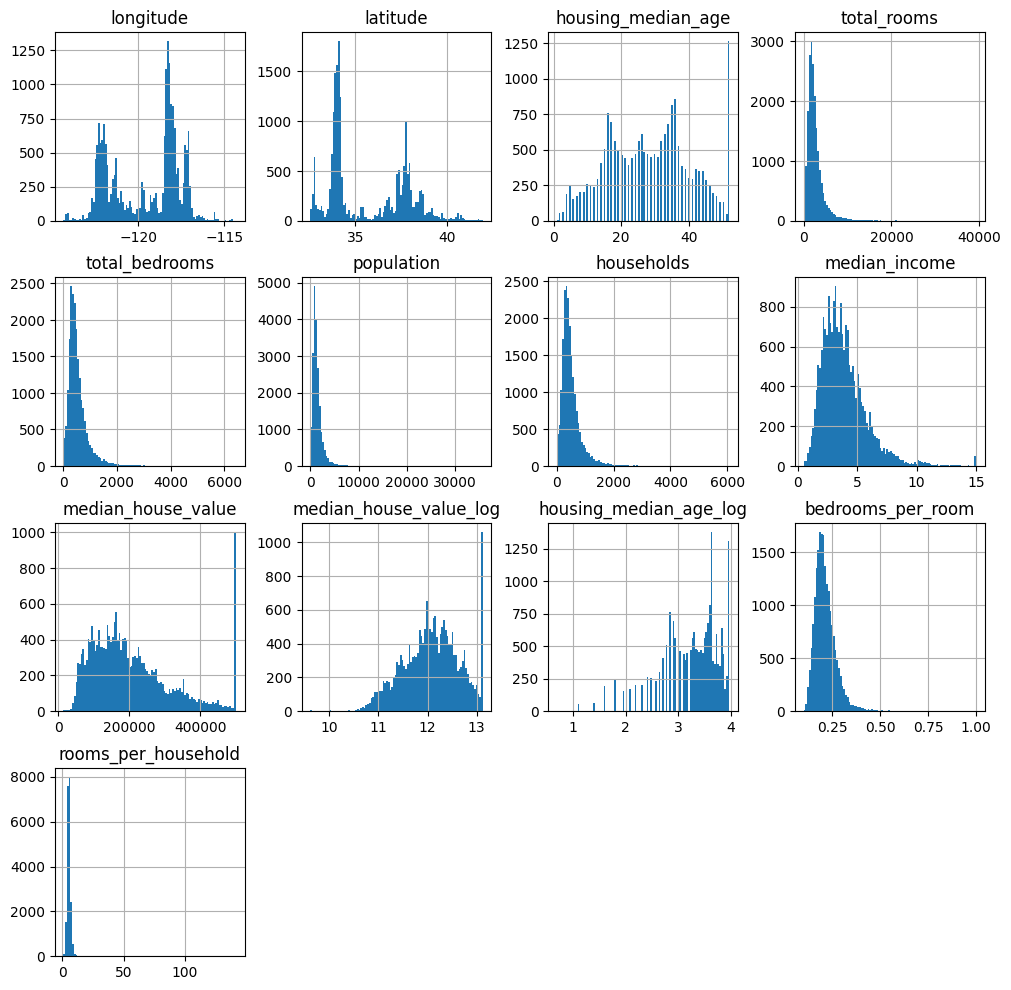

In [13]:
## Viewing distribution of data to determine the best corse of action for scaling
# Data shows heavy right tail scewing, log transformation will be applies
housing.hist(bins=100,figsize=(12,12))

<Axes: >

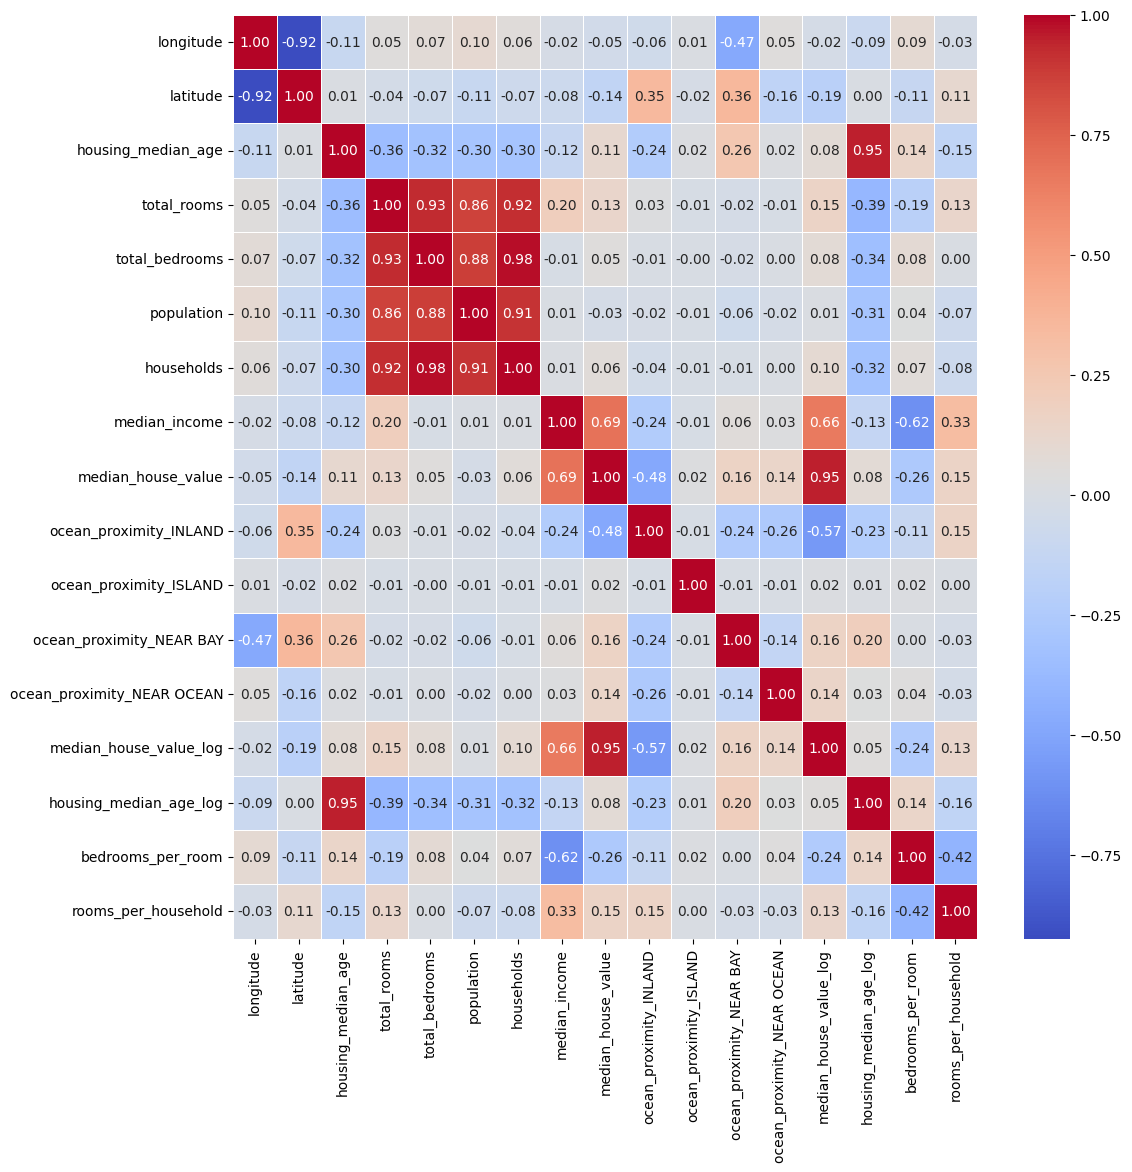

In [14]:
# Heatmap of features
correlation_matrix = housing.corr()
plt.figure(figsize=(12, 12))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)

In [15]:
## Set up split, removing features with lower corr
X = housing.drop(columns=['median_house_value_log', 'median_house_value','total_bedrooms','population','ocean_proximity_ISLAND','ocean_proximity_NEAR BAY','ocean_proximity_NEAR OCEAN','housing_median_age','households','total_rooms'])
y = housing['median_house_value_log']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print(X_train.shape, X_test.shape)

(14303, 7) (6130, 7)


In [16]:
print(X)
print(y)

       longitude  latitude  median_income  ocean_proximity_INLAND  \
0        -122.23     37.88         8.3252                   False   
1        -122.22     37.86         8.3014                   False   
2        -122.24     37.85         7.2574                   False   
3        -122.25     37.85         5.6431                   False   
4        -122.25     37.85         3.8462                   False   
...          ...       ...            ...                     ...   
20635    -121.09     39.48         1.5603                    True   
20636    -121.21     39.49         2.5568                    True   
20637    -121.22     39.43         1.7000                    True   
20638    -121.32     39.43         1.8672                    True   
20639    -121.24     39.37         2.3886                    True   

       housing_median_age_log  bedrooms_per_room  rooms_per_household  
0                    3.737670           0.146591             6.984127  
1                    3.0910

In [17]:
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)

print(f"R² Score (Random Forest): {r2_score(y_test, rf_pred):.4f}")

R² Score (Random Forest): 0.8350


In [18]:
train_r2 = r2_score(y_train, rf.predict(X_train))
test_r2 = r2_score(y_test, rf_pred)

print(f"Train R²: {train_r2:.4f}")
print(f"Test R²: {test_r2:.4f}")

Train R²: 0.9770
Test R²: 0.8350


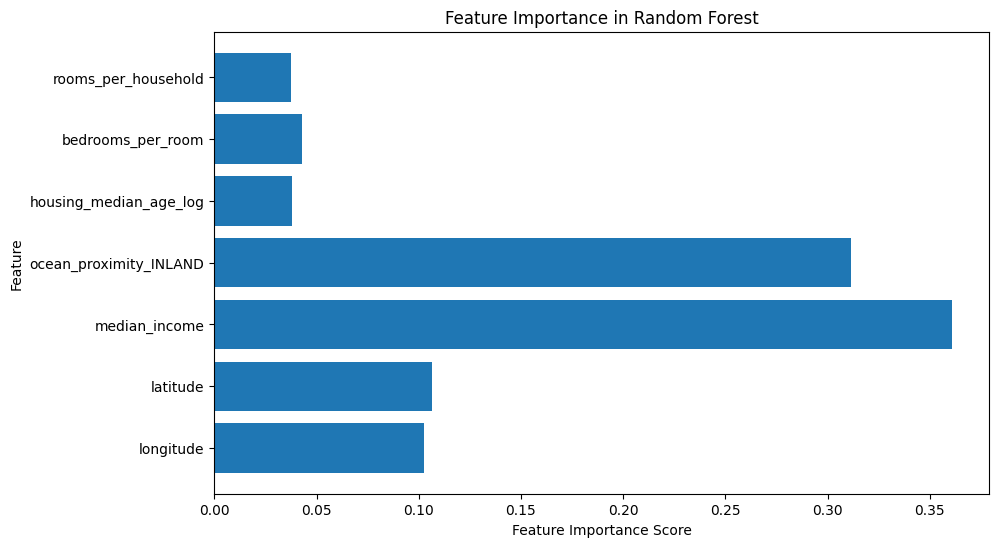

In [19]:
import matplotlib.pyplot as plt
import numpy as np

feature_importance = rf.feature_importances_
features = np.array(X_train.columns)

plt.figure(figsize=(10, 6))
plt.barh(features, feature_importance)
plt.xlabel("Feature Importance Score")
plt.ylabel("Feature")
plt.title("Feature Importance in Random Forest")
plt.show()

In [20]:
joblib.dump(rf, 'housing_price_model.pkl')

['housing_price_model.pkl']

In [21]:
loaded_model = joblib.load('housing_price_model.pkl')

In [22]:
### Review data for added clarity into features
print(housing['median_house_value'].describe())
print(X.describe())

count     20433.000000
mean     206864.413155
std      115435.667099
min       14999.000000
25%      119500.000000
50%      179700.000000
75%      264700.000000
max      500001.000000
Name: median_house_value, dtype: float64
          longitude      latitude  median_income  housing_median_age_log  \
count  20433.000000  20433.000000   20433.000000            20433.000000   
mean    -119.570689     35.633221       3.871162                3.271749   
std        2.003578      2.136348       1.899291                0.531451   
min     -124.350000     32.540000       0.499900                0.693147   
25%     -121.800000     33.930000       2.563700                2.944439   
50%     -118.490000     34.260000       3.536500                3.401197   
75%     -118.010000     37.720000       4.744000                3.637586   
max     -114.310000     41.950000      15.000100                3.970292   

       bedrooms_per_room  rooms_per_household  
count       20433.000000         20433.000

In [23]:
##### Gather input of new house to estimate price using model #####

def get_user_input():
    """Prompt user for necessary house features and return them as a formatted Pandas DataFrame."""
    print("\nWelcome! Please provide details about the house to predict its price.")
    
    try:
        # Collect user input for new house
        longitude = float(input("Enter Longitude (Higher = West; e.g., -119.0): "))
        latitude = float(input("Enter Latitude (Higher = North; e.g., 35.0): "))
        median_income = float(input("Enter Median Income (in thousands of dollars; e.g., 3.8): "))
        ocean_proximity_INLAND = float(input("Enter 1 if Inland, else 0: "))
        housing_median_age_log = float(input("Enter Housing Age (Lower is newer; e.g., 3.2): "))
        bedrooms_per_room = float(input("Enter Total Number of Bedrooms per Room count (e.g., 0.5): "))
        rooms_per_household = float(input("Enter Number of Rooms per Household (e.g., 3): "))

        # Convert to DataFrame with correct feature names
        columns = ['longitude', 'latitude', 'median_income', 'ocean_proximity_INLAND', 'housing_median_age_log', 
                 'bedrooms_per_room', 'rooms_per_household']

        user_input_df = pd.DataFrame([[longitude, latitude, median_income, ocean_proximity_INLAND, housing_median_age_log, 
                 bedrooms_per_room, rooms_per_household]], columns=columns)

        return user_input_df

    except ValueError as e:
        print(f"Error: {e}")
        return None

def predict_house_price():
    """Runs the user input function, preprocesses data, and predicts house price."""
    
    # Get user input
    user_input_df = get_user_input()
    if user_input_df is None:
        return  # Stop execution if input is invalid

    # Load the saved polynomial transformer & model
    trained_model = joblib.load('housing_price_model.pkl')

    # Make a prediction (log-transformed output, convert back)
    predicted_price_log = trained_model.predict(user_input_df)

    # Convert log-transformed prediction back to original price scale
    predicted_price = np.expm1(predicted_price_log)

    # Display the result
    print("\nPredicted House Price: **${:,.2f}**".format(predicted_price[0]))

# Run the prediction function
predict_house_price()


Welcome! Please provide details about the house to predict its price.


Enter Longitude (Higher = West; e.g., -119.0):  -110
Enter Latitude (Higher = North; e.g., 35.0):  29
Enter Median Income (in thousands of dollars; e.g., 3.8):  5
Enter 1 if Inland, else 0:  1
Enter Housing Age (Lower is newer; e.g., 3.2):  5
Enter Total Number of Bedrooms per Room count (e.g., 0.5):  5
Enter Number of Rooms per Household (e.g., 3):  5



Predicted House Price: **$130,465.33**
